In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.optimizers import SGD, Adam

# display results to 3 decimal points, not in scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
from google.colab import files
uploaded = files.upload()

# Data Pre-processing
Abbiamo pre-processato i dati andando ad eliminare i primi 2 secondi di dati in quanto abbiamo ritenuto non fossero direttamente collegati all'attivitá di estrazione o riposizionamento del telefono dalla tasca. 
Abbiamo inoltre sostituito la label con un formato numerico, piú adatto alla rete neurale rispetto alla stringa, formato piú human-readable.

       -11.190829530506305  3.0009236531244383     4812692749958   OTHER
0                  -11.049               3.097 4812713687750.000   OTHER
1                  -10.901               3.082 4812735548083.000   OTHER
2                  -10.820               3.089 4812756640667.000   OTHER
3                  -10.856               3.249 4812776832417.000   OTHER
4                  -10.928               3.438 4812799987083.000   OTHER
...                    ...                 ...               ...     ...
30854              -42.221               6.448 8413763419634.000  PICKUP
30855              -42.215               6.701 8413783611092.000  PICKUP
30856              -42.210               6.740 8413804683634.000  PICKUP
30857              -42.161               6.672 8413826482592.000  PICKUP
30858              -42.077                 NaN               NaN     NaN

[30859 rows x 4 columns]
OTHER values 13438

PICKUP values 4855

PUTDOWN values 0

OTHER values are 73.4597933635817% of th

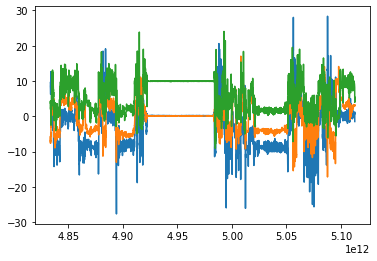

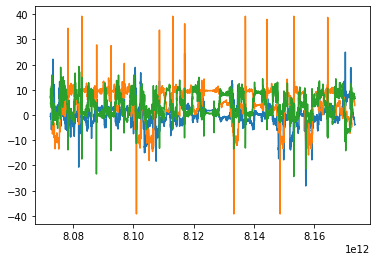

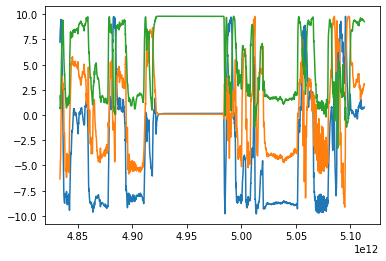

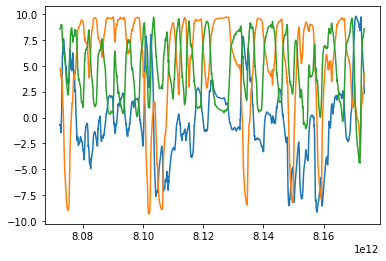

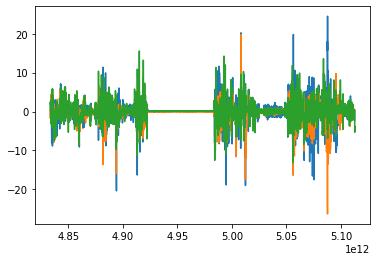

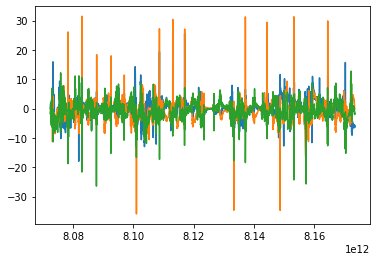

                   acceleration-x  acceleration-y  acceleration-z  label  \
timestamp                                                                  
4833537167677.000           9.546          -7.217           3.762      1   
4833557167677.000           9.190          -5.765           4.323      1   
4833564301927.000           9.190          -5.765           4.323      1   
4833578672218.000           8.865          -5.672           3.907      1   
4833598794677.000           7.902          -6.578           3.072      1   
...                           ...             ...             ...    ...   
8173386083561.000          -2.790           5.103           6.541      0   
8173406106936.000          -3.156           4.879           6.689      0   
8173427006477.000          -3.151           4.817           6.425      0   
8173449411561.000          -3.976           4.158           7.177      0   
8173468709102.000          -3.719           3.803           7.309      0   

           

In [ ]:
accelerometer = pd.read_csv("SensorData_Acc_0.csv")
gyroscope = pd.read_csv("SensorData_Gyr_0.csv")
rotation = pd.read_csv("SensorData_Rot_0.csv")
gravity = pd.read_csv("SensorData_Grav_0.csv")
linearAcceleration = pd.read_csv("SensorData_LinAcc_0.csv")

del accelerometer["Unnamed: 5"]
del gyroscope["Unnamed: 5"]
del rotation["Unnamed: 4"]
del gravity["Unnamed: 5"]
del linearAcceleration["Unnamed: 5"]

print(rotation)

accelerometer.columns = ["acceleration-x", "acceleration-y", "acceleration-z", "timestamp", "label"]
accelerometer.index = accelerometer["timestamp"]

gyroscope.columns = ["gyroscope-x", "gyroscope-y", "gyroscope-z", "timestamp", "label"]
gyroscope.index = gyroscope["timestamp"]

gravity.columns = ["gravity-x", "gravity-y", "gravity-z", "timestamp", "label"]
gravity.index = gravity["timestamp"]

#rotation.columns = ["rotation-x", "rotation-y", "rotation-z", "timestamp", "label"]
#rotation.index = rotation["timestamp"]

linearAcceleration.columns = ["linearAcceleration-x", "linearAcceleration-y", "linearAcceleration-z", "timestamp", "label"]
linearAcceleration.index = linearAcceleration["timestamp"]

del accelerometer["timestamp"]
del gyroscope["timestamp"]
del gyroscope["label"]
del gravity["timestamp"]
del gravity["label"]
del linearAcceleration["timestamp"]
del linearAcceleration["label"]
#del rotation["timestamp"]
#del rotation["label"]

merged = pd.merge(accelerometer, gyroscope, left_index=True, right_index=True)
merged = pd.merge(merged, gravity, left_index=True, right_index=True)
merged = pd.merge(merged, linearAcceleration, left_index=True, right_index=True)
#merged = pd.merge(merged, rotation, left_index=True, right_index=True)

merged.to_csv("merged.csv")
merged.dropna()

# 50 hz sampling rate, 600 sample/seconds, discard first two seconds of data
N = 1000 
merged = merged.iloc[N: , :]
 
# Removing last n rows
merged = merged.iloc[:-1000]

print(f"OTHER values {len(merged[(merged['label']=='OTHER')])}\n")
print(f"PICKUP values {len(merged[(merged['label']=='PICKUP')])}\n")
print(f"PUTDOWN values {len(merged[(merged['label']=='PUTDOWN')])}\n")

print(f"OTHER values are { (len(merged[(merged['label']=='OTHER')]) / len(merged)) * 100}% of the data\n")
print(f"PICKUP values are { (len(merged[(merged['label']=='PICKUP')]) / len(merged)) * 100}% of the data\n")
print(f"PUTDOWN values are { (len(merged[(merged['label']=='PUTDOWN')]) / len(merged)) * 100}% of the data\n")


print(merged.shape)

plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["acceleration-x"])
plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["acceleration-y"])
plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["acceleration-z"])

plt.show()

plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["acceleration-x"])
plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["acceleration-y"])
plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["acceleration-z"])

plt.show()

plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["gravity-x"])
plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["gravity-y"])
plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["gravity-z"])

plt.show()

plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["gravity-x"])
plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["gravity-y"])
plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["gravity-z"])

plt.show()

plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["linearAcceleration-x"])
plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["linearAcceleration-y"])
plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["linearAcceleration-z"])

plt.show()

plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["linearAcceleration-x"])
plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["linearAcceleration-y"])
plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["linearAcceleration-z"])

plt.show()


mapping = {'PICKUP': 0, 'OTHER': 1}
merged.replace({'label': mapping})

merged.label = [mapping[item] for item in merged.label]

print(merged)

training_data, testing_data = train_test_split(merged, test_size=0.25, random_state=25)

training_labels = training_data["label"]
del training_data["label"]

testing_labels = testing_data["label"]
del testing_data["label"]

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

print(training_data)

# Costruzione modello
Abbiamo quindi costruito un CNN utilizzando il modulo Tensorflow con diversi livelli.


In [ ]:
model = models.Sequential()

model.add(layers.Flatten())
model.add(layers.Dense(1000, activation="sigmoid"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(500, activation="sigmoid"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(training_data, training_labels, epochs=200, validation_data=(testing_data, testing_labels))
model.save(".")

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


428/429 [============================>.] - ETA: 0s - loss: 0.7893 - accuracy: 0.7735

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


429/429 [==============================] - 7s 14ms/step - loss: 0.7889 - accuracy: 0.7737 - val_loss: 0.3691 - val_accuracy: 0.8358
Epoch 2/200
429/429 [==============================] - 8s 18ms/step - loss: 0.3661 - accuracy: 0.8437 - val_loss: 0.3094 - val_accuracy: 0.8658
Epoch 3/200
429/429 [==============================] - 7s 17ms/step - loss: 0.3269 - accuracy: 0.8588 - val_loss: 0.2952 - val_accuracy: 0.8699
Epoch 4/200
429/429 [==============================] - 5s 13ms/step - loss: 0.2948 - accuracy: 0.8725 - val_loss: 0.3784 - val_accuracy: 0.8376
Epoch 5/200
429/429 [==============================] - 6s 13ms/step - loss: 0.2638 - accuracy: 0.8878 - val_loss: 0.2486 - val_accuracy: 0.8935
Epoch 6/200
429/429 [==============================] - 6s 13ms/step - loss: 0.2512 - accuracy: 0.8923 - val_loss: 0.2208 - val_accuracy: 0.9040
Epoch 7/200
429/429 [==============================] - 5s 12ms/step - loss: 0.2397 - accuracy: 0.8974 - val_loss: 0.2093 - val_accuracy: 0.9112
Epoc

# Model evaluation
Metriche per la valutazione del modello e della capacità predittiva

143/143 - 0s - loss: 0.0550 - accuracy: 0.9875 - 371ms/epoch - 3ms/step


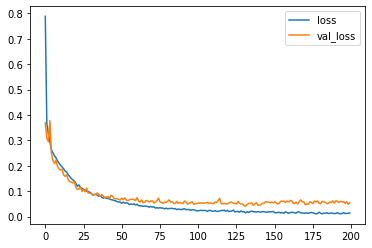

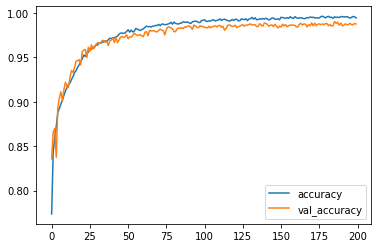

In [ ]:
test_loss, test_acc = model.evaluate(testing_data,  testing_labels, verbose=2)

metrics_df = pd.DataFrame(history.history)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(".") # path to the SavedModel directory
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)